# Background

## Load Libraries and MPC

In [1]:
import numpy as np
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
# libraries for point geometry 
import pandas as pd

from shapely.geometry import Polygon 

# library to access catalog
from pystac_client import Client
# used to sign items from the MPC STAC catalog 
import planetary_computer

from IPython.display import Image

import contextily as ctx # for adding basemaps

## Access collection with Biodiversity data

We want to access the `io-biodiversity` collection. First we need to load the catalog.

In [2]:
# access the catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier = planetary_computer.sign_inplace)


### Select the data of interest

Use the coordinats: [-112.826843, 32.974108, -111.184387, 33.863574]

Select the years: 2017 and 2020

In [3]:
# create bbox
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

#determine timerange
timerange = "2017/2020"

search = catalog.search(
    collections=["io-biodiversity"],
    #intersects=bbox_qazvin,
    bbox = bbox,
    datetime = timerange
)

items = search.item_collection()

# explore the items
items

In [4]:
# the 1st item in the collection is the 2020 raster
bio_20 = items[0]

# the 4thst item in the collection is the 2020 raster
bio_17 = items[3]

# Prepare Phoenix County Data

Read in the Arizona county shapefile:

In [5]:
# read the shapefile in for all Arizona coutnies
counties = gpd.read_file('data/tl_2022_04_cousub/tl_2022_04_cousub.shp')
counties.head(2)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,None,None,None,S,12231052883,44653332,+35.1066114,-111.3662497,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,None,None,None,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."


Select only Phoenix:

In [6]:
phoenix = counties[counties.NAME == "Phoenix"]

# check to see if correct polygon was selected
phoenix

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
10,04,013,92601,01934968,0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,None,None,None,S,2806478817,9471127,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


## Create a map 

Show the Phoenix subdivision within an appropriate geographical context. You may use any vector datasets to create your map. 

Text(0.5, 1.0, 'SB County')

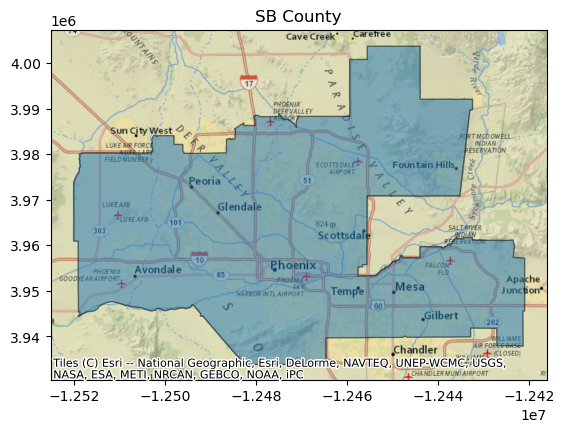

In [7]:
fig, ax = plt.subplots()

(phoenix.to_crs(epsg=3857)
.plot(ax = ax, 
     figsize = (5,5),
     alpha = 0.5,
     edgecolor = 'k')
)

# add basemap
ctx.add_basemap(ax, 
               source = ctx.providers.Esri.NatGeoWorldMap)

ax.set_title('SB County')

## Calculate the percentage of area 

Phoenix subdivision with a BII of at least 0.75 in 2017. Obtain the same calculation for 2020.

In [8]:
Image(url = bio_20.assets['rendered_preview'].href, width = 500)

In [9]:
# open the rasters
phoenix_20 = rioxr.open_rasterio(bio_20.assets['data'].href)
phoenix_17 = rioxr.open_rasterio(bio_17.assets['data'].href)

In [10]:
# get the shape of phoenix
phx_20 = phoenix_20.rio.clip(phoenix['geometry'])


In [11]:
#phx_17 = phoenix_17.rio.clip(phoenix['geometry'])

KeyboardInterrupt: 

In [19]:
# select the values that are greater than 0.75 from the 2020 data 
bii_phoenix_20 = phx_20>=0.75
bii_phoenix_20

<xarray.DataArray (band: 1, y: 583, x: 990)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29 33.29
    spatial_ref  int64 0

In [21]:
bii_20 = bii_phoenix_20.astype(int)
bii_20

<xarray.DataArray (band: 1, y: 583, x: 990)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29 33.29
    spatial_ref  int64 0

In [ ]:
# select the values that are greater than 0.75 from the 2017 data 
#bii_phoenix_17 = phoenix_17>=0.75

In [13]:
# change back to integer instead of bool values
#bii_phoenix_17 = bii_phoenix_17.astype(int)

In [22]:
bii_20.rio.crs

CRS.from_epsg(4326)

Text(0.5, 1.0, 'SB County')

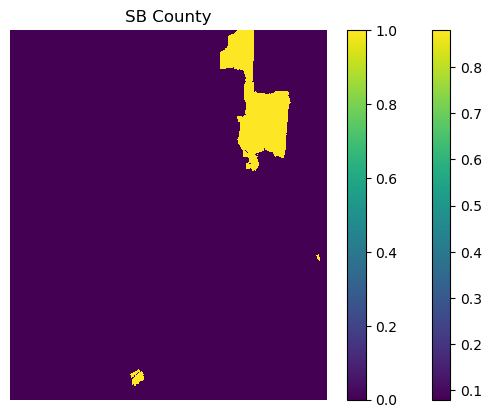

In [25]:
fig, ax = plt.subplots()
ax.axis('off')
phx_20.plot(ax = ax)
bii_phoenix_20.plot(ax = ax)


ax.set_title('SB County')

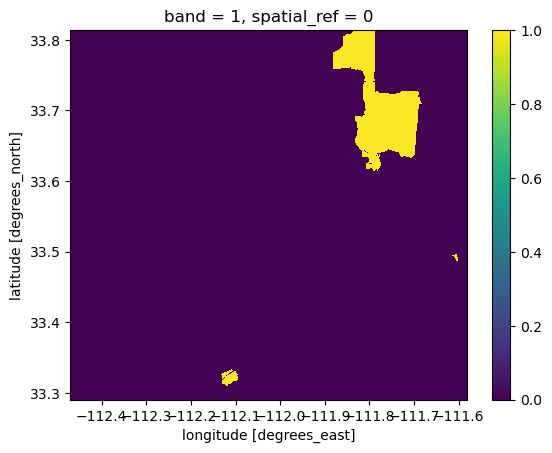

In [29]:


# set the 0s to NA values
bii_20.plot()

